- https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/
- https://www.sbert.net/examples/training/data_augmentation/README.html
sentence vectorizer

- https://www.kaggle.com/quentinfu/word2vec-and-lstm-98-accuracy
- https://www.youtube.com/watch?v=TsXR7_vtusQ

In [60]:
import pandas as pd
import numpy as np

from collections import Counter
from itertools import chain

from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm.notebook import tqdm

tokenizer = Tokenizer()

import gensim
import re
from eunjeon import Mecab


import matplotlib.pyplot as plt
import seaborn as sns

#한글 시각화
import matplotlib
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

In [61]:
train = pd.read_csv('news_train.csv')
test = pd.read_csv('news_test.csv')

train.head(6)

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0
5,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",[이데일리 권오석 기자] 중소벤처기업부(이하 중기부)는 대한민국 동행세일에 7개 T...,2,0


In [120]:
len(list(set(train['n_id'])))

3688

In [121]:
len(list(set(test['n_id'])))

5126

##### 데이터 정제

In [1]:
def text_preprocessing(text_list):
    token_list = []
    stopwords = ['습니다','됩니다','는다' , '으로', 'null' , '으로', 
                 '에서', '된다', '면서', '다는', '대한', '는데', '다고','라고', '부터']
    #tokenizer = Kkma()
    tokenizer = Mecab()
    
    for index, text in enumerate(tqdm(text_list)):
        txt = re.sub('[^가-힣a-z]', ' ', text.lower())
        token = tokenizer.morphs(txt)
        token = [t for t in token if t not in stopwords]
        token = [t for t in token if (len(t) >=2) | (t in ['미','러','북','北' , '韓', '日', '中'])]
        token_list.append(token)
        
    return token_list


train.loc[:, 'titleToken'] = text_preprocessing(train['title'])
train.loc[:, 'contentToken'] = text_preprocessing(train['content'])

test.loc[:, 'titleToken'] = text_preprocessing(test['title'])
test.loc[:, 'contentToken'] = text_preprocessing(test['content'])

##### 가짜뉴스, 진짜뉴스 별 token확인

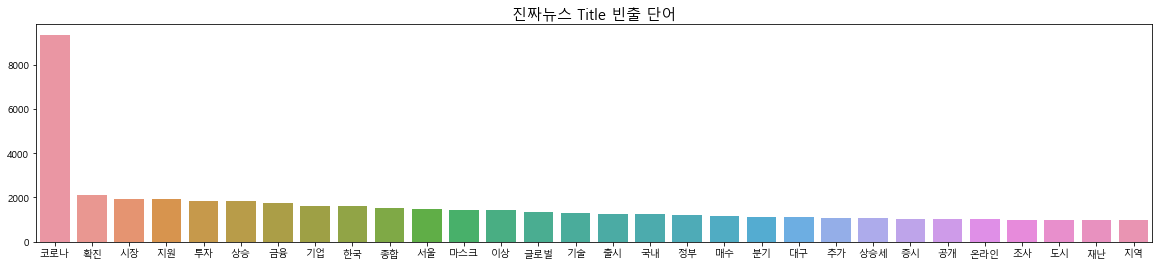

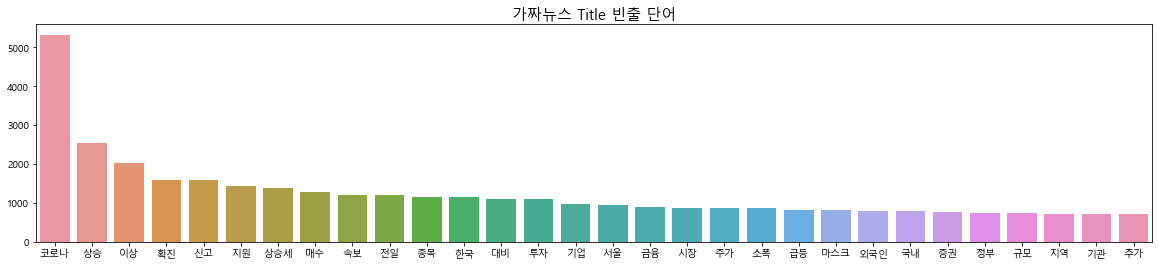

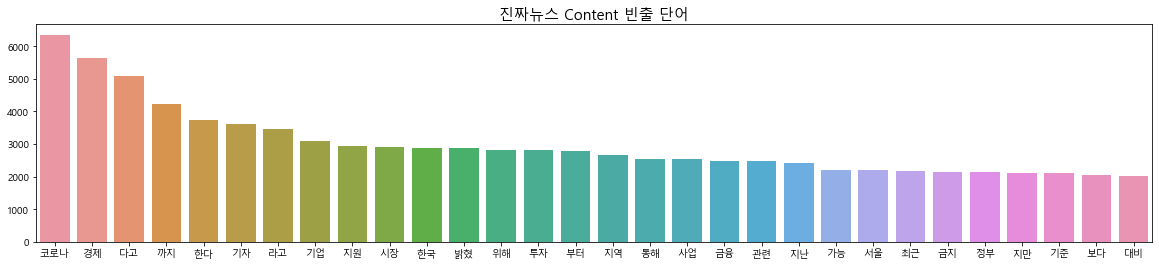

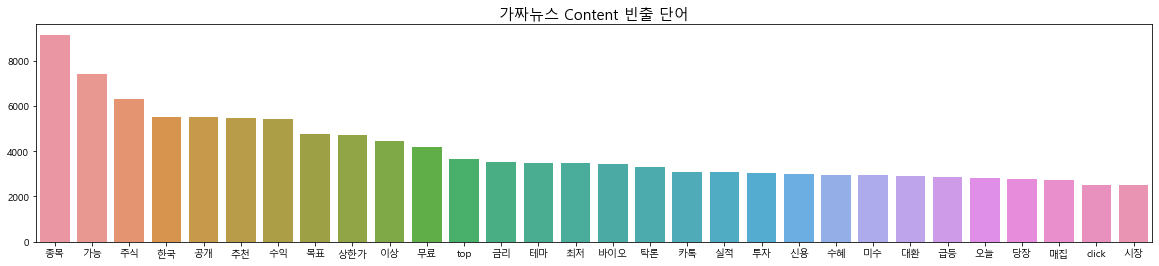

In [18]:
import collections


#가짜뉴스, 진짜뉴스별 단어 Count
trueTitleNounList = [i for i in train.loc[train['info'] == 0 , 'titleToken'].values]
fakeTitleNounList = [i for i in train.loc[train['info'] == 1 , 'titleToken'].values]
trueContentNounList = [i for i in train.loc[train['info'] == 0 , 'contentToken'].values]
fakeContentNounList = [i for i in train.loc[train['info'] == 1 , 'contentToken'].values]


trueTitleCounter = collections.Counter([x for sublist in trueTitleNounList for x in sublist])
fakeTitleCounter = collections.Counter([x for sublist in fakeTitleNounList for x in sublist])
trueContentCounter = collections.Counter([x for sublist in trueContentNounList for x in sublist])
fakeContentCounter = collections.Counter([x for sublist in fakeContentNounList for x in sublist])



##1. 진짜뉴스 Title 시각화
plt.figure(figsize = (20, 4))
sns.barplot(x = [i[0] for i in trueTitleCounter.most_common(30)],
          y = [i[1] for i in trueTitleCounter.most_common(30)])
plt.title('진짜뉴스 Title 빈출 단어', fontsize = 15)
plt.show()


##2. 가짜뉴스 Title 시각화
plt.figure(figsize = (20, 4))
sns.barplot(x = [i[0] for i in fakeTitleCounter.most_common(30)],
          y = [i[1] for i in fakeTitleCounter.most_common(30)])
plt.title('가짜뉴스 Title 빈출 단어', fontsize = 15)
plt.show()

##3. 진짜뉴스 content 시각화
plt.figure(figsize = (20, 4))
sns.barplot(x = [i[0] for i in trueContentCounter.most_common(30)],
          y = [i[1] for i in trueContentCounter.most_common(30)])
plt.title('진짜뉴스 Content 빈출 단어', fontsize = 15)
plt.show()

##4. 가짜뉴스 content 시각화
plt.figure(figsize = (20, 4))
sns.barplot(x = [i[0] for i in fakeContentCounter.most_common(30)],
          y = [i[1] for i in fakeContentCounter.most_common(30)])
plt.title('가짜뉴스 Content 빈출 단어', fontsize = 15)
plt.show()

##### <center>Doc2Vec</center>

##### doc2vec 학습용 데이터셋 구축

In [20]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#학습량을 늘리고자 , Train, Test 모두 사용
titleTokenSent = list(train['titleToken'].values) + list(test['titleToken'].values)
contentTokenSent = list(train['contentToken'].values) + list(test['contentToken'].values)

tagged_title = [TaggedDocument(d, ['title_' + str(i)]) for i, d in enumerate(titleTokenSent)]
tagged_content = [TaggedDocument(d, ['content_' + str(i)]) for i, d in enumerate(contentTokenSent)]

tagged_data = tagged_title + tagged_content

In [22]:
model = Doc2Vec(tagged_data, vector_size = 100, window = 2, min_count = 1, verbose = 1, epoch = 10)

model.infer_vector(train.loc[0, 'titleToken'])

array([ 0.01196892, -0.01703835,  0.03282651, -0.00015121,  0.00257444,
        0.0065877 ,  0.00038528, -0.0283552 , -0.0175379 , -0.00345283,
        0.03892214,  0.02173506,  0.00017624,  0.02526559, -0.00500074,
        0.00086537,  0.00831356,  0.00463991,  0.00604195,  0.00604293,
        0.00513969,  0.00712729, -0.03478484,  0.00671188,  0.01958649,
       -0.00147584, -0.00781725, -0.01164418, -0.00436263, -0.00651098,
        0.02419601,  0.03192189, -0.01864433, -0.03370372, -0.00707891,
        0.02594826,  0.0347061 ,  0.00705332, -0.00261844,  0.01467286,
        0.01314398, -0.01809525,  0.0321585 ,  0.00411598,  0.02825506,
       -0.03011495, -0.01206097, -0.01401468, -0.02061606,  0.00306438,
       -0.00258939, -0.0060707 , -0.00433923,  0.0022086 ,  0.045856  ,
       -0.01588488,  0.00438131, -0.00875435, -0.03355421,  0.00066266,
        0.02001841,  0.00628924, -0.00946352, -0.00586761, -0.00755067,
        0.02136491,  0.00083155, -0.0195186 , -0.00874927,  0.01

In [23]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

##### 제목과 내용의 유사도 구하기

In [2]:
train_title = list(train['titleToken'].values)
train_content = list(train['contentToken'].values)


train_sim = [cosine(model.infer_vector(title), model.infer_vector(content)) for title, content in tqdm(zip(train_title, train_content))]


test_title = list(test['titleToken'].values)
test_content = list(test['contentToken'].values)


test_sim = [cosine(model.infer_vector(title), model.infer_vector(content)) for title, content in tqdm(zip(test_title, test_content))]

In [25]:
train['sim'] = train_sim
test['sim'] = test_sim
train.head(10)

,n_id,date,title,content,ord,info,titleToken,contentToken,sim
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,"[마감, 코스닥, 기관, 순매도]","[데일리, marketpoint, 현재, 코스닥, 기관, 순매도]",0.349228
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,"[마감, 코스닥, 기관, 순매도]","[실적, 기반, 저가, 매집, 해야, 급등, 유망주, top, 전격, 공개]",0.514106
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,"[마감, 코스닥, 기관, 순매도]","[하이스, 탁론, 선취, 수수료, 최저, 금리, 상품, 출시]",0.740146
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,"[마감, 코스닥, 기관, 순매도]","[종합, 경제, 정보, 미디어, 데일리, 무단, 전재, 배포, 금지]",0.597437
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,"[롯데, 공영, tv, 쇼핑, 동행, 세일, 동참]","[전국, 소비, 조성, 기여, 예정]",-0.232507
5,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",[이데일리 권오석 기자] 중소벤처기업부(이하 중기부)는 대한민국 동행세일에 7개 T...,2,0,"[롯데, 공영, tv, 쇼핑, 동행, 세일, 동참]","[데일리, 권오석, 기자, 중소, 벤처, 기업, 이하, 기부, 대한민국, 동행, 세...",0.375867
6,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참","대한민국 동행세일은 라이브 커머스, 언택트 콘서트, O2O 행사 연계 등 비대면이라...",3,0,"[롯데, 공영, tv, 쇼핑, 동행, 세일, 동참]","[대한민국, 동행, 세일, 라이브, 커머스, 택트, 콘서트, 행사, 연계, 대면, ...",0.505593
7,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참","6개 권역에서의 현장행사와 온·오프라인 판촉, TV홈쇼핑 등 연계행사를 통해 소비심...",4,0,"[롯데, 공영, tv, 쇼핑, 동행, 세일, 동참]","[권역, 현장, 행사, 오프라인, 판촉, tv, 쇼핑, 연계, 행사, 통해, 소비,...",0.468138
8,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",이번 동행세일에서는 롯데·공영·CJ·현대·GS·NS·홈앤쇼핑 등 7개 TV 홈쇼핑사...,5,0,"[롯데, 공영, tv, 쇼핑, 동행, 세일, 동참]","[이번, 동행, 세일, 롯데, 공영, cj, 현대, gs, ns, 쇼핑, tv, 쇼...",0.092967
9,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참","동행세일 기간 중 홈쇼핑사에서는 판매방송 사이에 영상을 노출하는 방식(SB, sta...",6,0,"[롯데, 공영, tv, 쇼핑, 동행, 세일, 동참]","[동행, 세일, 기간, 쇼핑, 판매, 방송, 사이, 영상, 노출, 방식, sb, s...",0.283796


##### 문장들을 벡터로 변환

In [3]:
train_X = [np.append(model.infer_vector(title) , model.infer_vector(content))for title,content in tqdm(zip(train_title, train_content))]
test_X = [np.append(model.infer_vector(title) , model.infer_vector(content))for title,content in tqdm(zip(test_title, test_content))]

train_y = train['info'].values

In [31]:
from sklearn.model_selection import train_test_split
import lightgbm as lgbm

In [83]:
df_train_X = pd.DataFrame(train_X)
df_train_X['sim'] = train_sim
df_train_X.tail()

,101,102,103,104,105,106,107,108,109,110,...,191,192,193,194,195,196,197,198,199,sim
63366,-0.002845,0.018380,-0.038949,0.074185,-0.032890,0.008840,0.030532,0.075979,0.058186,0.023637,...,-0.022077,0.012728,0.046227,0.088141,0.110291,-0.037086,-0.021948,0.034137,-0.036302,0.082821
97981,-0.000233,-0.003849,0.001753,-0.000600,-0.001167,0.004186,-0.005015,0.000192,0.003532,0.002076,...,-0.003035,-0.003515,0.002512,-0.002044,-0.000389,-0.005118,-0.001440,-0.002598,0.004024,0.438900
13265,-0.005284,0.024862,-0.003954,0.008726,-0.012073,-0.000937,-0.031847,-0.012509,-0.026627,0.023057,...,-0.026557,0.007263,-0.013357,-0.023547,-0.013580,-0.005645,-0.006224,0.034937,-0.013038,0.774566
98325,0.009495,0.010864,-0.003529,0.003196,-0.010305,0.002837,-0.012600,0.008339,-0.011475,0.020891,...,-0.020463,0.013101,-0.017038,-0.011832,-0.001880,0.011159,-0.003630,0.019667,0.010037,0.253479
30789,0.054073,-0.079247,-0.003162,0.042745,-0.065271,0.033838,0.028977,-0.035154,0.082972,0.002445,...,0.045620,-0.047377,0.030438,-0.022875,0.009619,-0.026871,-0.001026,-0.053990,0.001351,-0.135141


In [86]:
train_X, val_X, train_y, val_y = train_test_split(df_train_X, train_y)
print(train_X.shape, val_X.shape)
print(train_y.shape, val_y.shape)

(66793, 100) (22265, 100)
(66793,) (22265,)


##### LightGBM

In [87]:
lgbModel = lgbm.LGBMClassifier(num_leaves = 127)
lgbModel.fit(X = train_X, y= train_y)

LGBMClassifier(num_leaves=127)

In [89]:

print(accuracy_score(val_y, lgbModel.predict(X = pd.DataFrame(val_X))))

0.9059510442398383


>- 90.5% 상당히 좋지 않음

##### 검증용 데이터를 통해 얼마나 맞는지 한번 확인

In [94]:
v = train.loc[pd.DataFrame(val_X).index]
v['pred'] = lgbModel.predict(X = pd.DataFrame(val_X))
v

,n_id,date,title,content,ord,info,pred
21347,NEWS05766,20200619,"'일지테크' 10% 이상 상승, 전일 외국인 대량 순매수",반면 그동안 외국인은 16.6만주를 순매도했다,2,0,0
86886,NEWS04388,20200326,씨유메디칼 19.24% 이상 급등 중,동종목의 경우 동기간 일평균 주가변동률은 4.82%를 기록했다,10,0,0
24714,NEWS00765,20200227,"'에스앤에스텍' 52주 신고가 경신, 2019.3Q, 매출액 241억(+56.7%)...","""100만원""만 있어도 지금 당장 ""이것""부터 사라.. .",5,1,1
87426,NEWS06170,20200328,"아베 ""日, 대규모 경제대책 마련할것""",지자체 외출자제 요청에 응해달라,34,0,0
57273,NEWS01815,20200330,"유럽 내 한국기업, 10곳 중 9곳 코로나19 피해 ‘심각’",똑똑해진 소비자..한국도 이젠 소형차 시대,41,1,1
...,...,...,...,...,...,...,...
41227,NEWS01190,20200527,"SK하이닉스, 외국인 4만 9315주 순매수… 주가 0.49%","SK하이닉스, 투자자 검색 급증... 주가 8만 1200원(-0.12%)",14,1,0
6332,NEWS03804,20200605,"안랩, 클라우드 워크로드 보안 플랫폼 `안랩 CPP` 출시","""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",8,1,1
74255,NEWS05037,20200320,“묻고 더블로”…주가지수 ‘베팅’장 된 시중은행,주식시장의 역사를 다시 쓸 역대급 종목. 목표 1700% 이상.,47,1,1
14116,NEWS07093,20200508,"최태원 SK 회장, 스포츠단 화상 격려…""국민 힘 돼달라""",최 회장은 스포츠야말로 코로나19로 지친 국민들에게 힘과 용기를 줄 수 있는 각본없...,7,0,0
